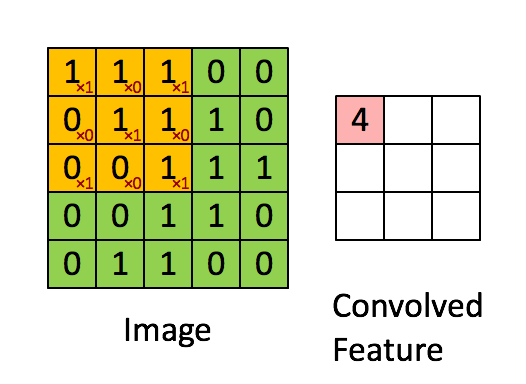

 The structure of this network follows the classic structure of CNNs, which is a mix of convolutional layers and max pooling, followed by fully-connected layers.

The code you'll be looking at is similar to what you saw in the segment on Deep Neural Network in TensorFlow in the previous lesson, except we restructured the architecture of this network as a CNN.



# Dataset
Here we're importing the MNIST dataset and performing batch, scale, and One-Hot encode the data.



In [2]:
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    assert len(features) == len(labels)
    outout_batches = []
    
    sample_size = len(features)
    for start_i in range(0, sample_size, batch_size):
        end_i = start_i + batch_size
        batch = [features[start_i:end_i], labels[start_i:end_i]]
        outout_batches.append(batch)
        
    return outout_batches

In [3]:
import numpy as np

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow import keras
from keras import backend as k




(x_train, y_train) , (x_test, y_test) = keras.datasets.mnist.load_data()


# Flattening the matrix for training set and test set
# x_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
# x_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32') 


# one hot encoding for the lables in train and test
temp_train = np.zeros([y_train.shape[0],y_train.max()+1],dtype = np.float32)
temp_train[np.arange(y_train.shape[0]),y_train] = 1
y_train = temp_train

temp_test = np.zeros([y_test.shape[0],y_test.max()+1],dtype = np.float32)
temp_test[np.arange(y_test.shape[0]),y_test] = 1
y_test = temp_test

# Applying Channels in the image
img_rows, img_cols=28, 28

if k.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    inpx = (1, img_rows, img_cols)

else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    inpx = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255


# Parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units


Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 10)
(10000, 10)


# Weights and Biases

weight = tf.Variable(tf.truncated_normal(
    [filter_size_height, filter_size_width, color_channels, k_output]))
    
bias = tf.Variable(tf.zeros(k_output))


In [7]:
# Store layers weight & bias
weights = {
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])), #flattened output gives 7*7*64 and 1024 is number 
                                                          # of neurons of 1st layer of FC network  
    'out': tf.Variable(tf.random_normal([1024, n_classes]))}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))}


In [8]:
biases['bd1']

<tf.Variable 'Variable_14:0' shape=(1024,) dtype=float32_ref>

<img src="attachment:e57a82cb-08bc-481f-97b4-697dad2c4952.gif" width="500" height="200">

The above is an example of a convolution with a 3x3 filter and a stride of 1 being applied to data with a range of 0 to 1. The convolution for each 3x3 section is calculated against the weight, [[1, 0, 1], [0, 1, 0], [1, 0, 1]], then a bias is added to create the convolved feature on the right. In this case, the bias is zero. In TensorFlow, this is all done using tf.nn.conv2d() and tf.nn.bias_add().



TensorFlow uses the following equation for 'SAME' vs 'VALID'

SAME Padding, the output height and width are computed as:

out_height = ceil(float(in_height) / float(strides[1]))

out_width = ceil(float(in_width) / float(strides[2]))

VALID Padding, the output height and width are computed as:

out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))

out_width = ceil(float(in_width - filter_width + 1) / float(strides[2]))


In [6]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


The tf.nn.conv2d() function computes the convolution against weight W as shown above.

In TensorFlow, strides is an array of 4 elements; the first element in this array indicates the stride for batch and last element indicates stride for features. It's good practice to remove the batches or features you want to skip from the data set rather than use a stride to skip them. You can always set the first and last element to 1 in strides in order to use all batches and features.

The middle two elements are the strides for height and width respectively. I've mentioned stride as one number because you usually have a square stride where height = width. When someone says they are using a stride of 3, they usually mean tf.nn.conv2d(x, W, strides=[1, 3, 3, 1]).

To make things easier, the code is using tf.nn.bias_add() to add the bias. Using tf.add() doesn't work when the tensors aren't the same shape.



# Max Pooling

<img src="attachment:754e6251-e3a7-4315-b525-b088d9daaef6.png" width="500" height="200">


In [7]:
def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='SAME')


The tf.nn.max_pool() function does exactly what you would expect, it performs max pooling with the ksize parameter as the size of the filter.



# Model

<img src="attachment:4e839b99-3e97-466f-b36f-f66996f37647.png" width="500" height="200" />


In the code below, we're creating 3 layers alternating between convolutions and max pooling followed by a fully connected and output layer. The transformation of each layer to new dimensions are shown in the comments. For example, the first layer shapes the images from 28x28x1 to 28x28x32 in the convolution step. Then next step applies max pooling, turning each sample into 14x14x32. All the layers are applied from conv1 to output, producing 10 class predictions.



In [8]:
def conv_net(x, weights, biases, dropout):
    # Layer 1 - 28*28*1 to 14*14*32 since for pooling the stride will be 2 
    # output of pooling for same padding is out_height = ceil(float(in_height) / float(strides[1]))
    # ceil((28)/2) = 14
    # Shape of weights['wc1'] is (5, 5, 1, 32) and biases['bc1'] is (32,)
    conv1 = conv2d(x, weights['wc1'], biases['bc1']) # Output Shape here is 28x28x32
    conv1 = maxpool2d(conv1, k=2) # Output Shape here is 14x14x32

    # Layer 2 - 14*14*32 to 7*7*64
    # Shape of weights['wc2'] is (5, 5, 32, 64) and biases['bc2'] is (64,)
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2']) # Output Shape here is 14x14x64
    conv2 = maxpool2d(conv2, k=2) # Output Shape here is 7x7x64

    # Fully connected layer - 7*7*64 = 3136 to 1024 
    # shape of  weights['wd1'] is (3136, 1024) and shape of biases['bd1'] is (1024,) 
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]]) # Flattening the output 7x7x64
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out


In [ ]:
# tf Graph input
x = tf.placeholder(tf.float32, [None, 28, 28, 1])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# Model
logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(\
    tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)\
    .minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf. global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)

    for epoch in range(epochs):
        batch = 0
        for batch_x, batch_y in batches(batch_size, x_train, y_train):
            batch += 1
            sess.run(optimizer, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: dropout})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: x_test,
                y: y_test,
                keep_prob: 1.})
            
        # Print status for every 10 epochs
       # if epoch % 10 == 0:
            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))

    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: x_test,
        y: y_test,
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Epoch  1, Batch   2 -Loss: 55224.2461 Validation Accuracy: 0.092400
Epoch  1, Batch   3 -Loss: 43446.0703 Validation Accuracy: 0.105100
Epoch  1, Batch   4 -Loss: 39467.3633 Validation Accuracy: 0.105600
Epoch  1, Batch   5 -Loss: 29214.5820 Validation Accuracy: 0.118400
Epoch  1, Batch   6 -Loss: 27932.2363 Validation Accuracy: 0.110300
Epoch  1, Batch   7 -Loss: 27398.3633 Validation Accuracy: 0.109500
Epoch  1, Batch   8 -Loss: 24542.7793 Validation Accuracy: 0.115100
Epoch  1, Batch   9 -Loss: 26589.3477 Validation Accuracy: 0.116900
Epoch  1, Batch  10 -Loss: 22589.0020 Validation Accuracy: 0.143300
Epoch  1, Batch  11 -Loss: 23184.1836 Validation Accuracy: 0.135000
Epoch  1, Batc